## Imports and configuration

In [71]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titlepad'] = 20

PARTIES = ['D', 'R']
PARTY_NAME = {'D': 'Democrat', 'R':'Republican', '3':'Third-Party', 'I':'Independent', 'U':'Unknown', 'L': 'Libertarian'}
PARTY_COLORS = {'D': '#3498db', 'R':'#e74c3c', '3':'#9b59b6', 'I':'#2ecc71', 'U':'#34495e', 'L': '#AAAAAA'} #TODO: add colors from the fivethirtyeight palette instead

## Loading data

In [2]:
def _csv_records(filename, all_pipe_sep):
    with open(filename) as f:
        for line in f:
            if all_pipe_sep:
                yield [t.strip()[:-1].strip() for t in line[1:].split(',|')]
            else:
                yield [t.replace('|', '').strip() for t in line.split(',')]


def csv_to_dataframe(filename, cols=None, all_pipe_sep=True):
    df = pd.DataFrame(_csv_records(filename, all_pipe_sep), columns=cols or [])
    for col in df:
        if set(df[col].unique()) == {'', 'Y'}:
            df[col] = (df[col] == 'Y')
        else:
            df[col] = df[col].replace('', None)
    return df

In [3]:
# Candidates
columns = ['cycle', 'fecc_and_id', 'c_id', 'name', 'party', 'dist_id_run_for', 'dist_id_curr', 'curr_cand', 'cycle_cand', 'crpico', 'recipcode', 'no_pacs']
cands = csv_to_dataframe('data/campaign_finance/cands16.txt', cols=columns)
crpico = dict(I='incumbent', C='challenger', O='open_seat', U='unknown')
cands['crpico'] = cands['crpico'].apply(lambda s : crpico[s] if s in crpico else s or None)

In [4]:
# PACS contributions
columns = ['cycle', 'fec_rec_no', 'pac_id', 'c_id', 'amount', 'date', 'real_code', 'type', 'di', 'fecc_and_id']
pacs = csv_to_dataframe('data/campaign_finance/pacs16.txt', all_pipe_sep=False, cols=columns)

pacs['amount'] =  pacs['amount'].astype(pd.np.int)
pacs['date'] = pd.to_datetime(pacs['date'], dayfirst=False, infer_datetime_format=True)
# Removing some unexpected values
pacs = pacs[pacs['amount'] > 0]
pacs = pacs[(pacs['date'] >= pd.datetime(2014, 12, 1)) & (pacs['date'] < pd.datetime(2017, 1, 1))]

In [5]:
# Union of candidates/PACS contributions
df = pacs.merge(cands, on=['c_id', 'cycle']).sort_values('date')

## Visualization

In [6]:
cands.sample(3, random_state=0)

,cycle,fecc_and_id,c_id,name,party,dist_id_run_for,dist_id_curr,curr_cand,cycle_cand,crpico,recipcode,no_pacs
2065,2016,P60009735,N00037569,Christopher Farnell (R),R,PRES,NV03,False,False,open_seat,RN,False
5020,2016,H6NV02222,N00028586,Glenn Thomas (R),R,NV02,NJ08,False,False,incumbent,RN,False
6100,2016,H0TN03304,N00032397,Mo Kiah (I),I,TN03,SD01,False,False,incumbent,3N,False


In [7]:
pacs.sample(3, random_state=0)

,cycle,fec_rec_no,pac_id,c_id,amount,date,real_code,type,di,fecc_and_id
214224,2016,4101520151255739620,C00024968,N00029139,2500,2015-09-30,H1120,24K,D,H8IL14067
232030,2016,4062220161299995890,C00571646,N00031064,2700,2016-05-19,J2200,24K,D,H0PA06076
20967,2016,4103120161345634178,C00489112,N00000851,5000,2016-09-29,J2200,24K,D,H2NJ02037


In [8]:
df.sample(3, random_state=0)

,cycle,fec_rec_no,pac_id,c_id,amount,date,real_code,type,di,fecc_and_id_x,fecc_and_id_y,name,party,dist_id_run_for,dist_id_curr,curr_cand,cycle_cand,crpico,recipcode,no_pacs
389353,2016,4120220161356503091,C00502518,N00025292,5000,2016-10-28,E1120,24K,D,H2UT01094,H2UT01094,Rob Bishop (R),R,UT01,UT01,True,True,incumbent,RW,False
376125,2016,4080220161307749108,C00609750,N00000528,957,2016-05-03,Y0000,24E,I,P60007168,S4VT00033,Bernie Sanders (D),D,PRES,VTS1,False,False,incumbent,DI,False
403956,2016,4061420161298847978,C00575373,N00033085,51502,2016-01-14,J1100,24E,I,P60006111,S2TX00312,Ted Cruz (R),R,TXS2,TXS2,False,False,incumbent,RI,False


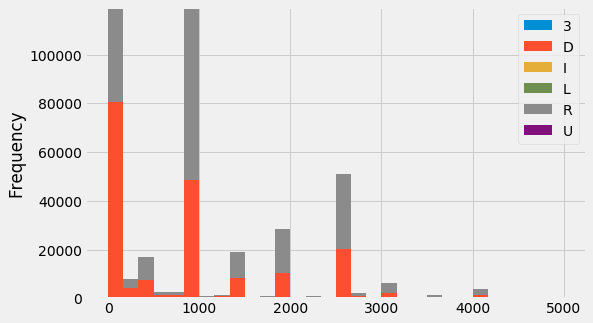

In [69]:
t_df = df[df.amount < df.amount.quantile(.95)]
t_df = t_df.pivot_table('amount', t_df.index, 'party')
fig = t_df.plot.hist(stacked=True, bins=30)
_ = plt.legend()

In [10]:
amount_per_week = df.resample('7D', on='date').amount

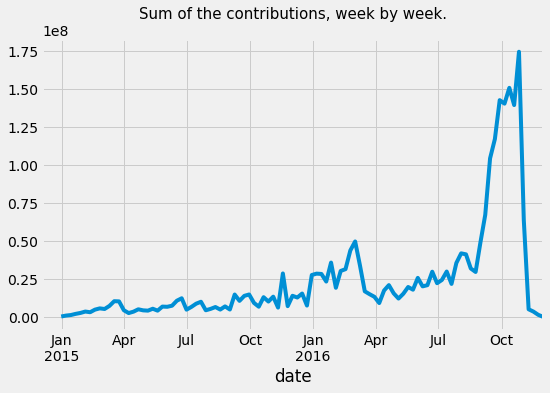

In [51]:
amount_per_week.sum().plot.line()
_ = plt.title('Sum of the contributions, week by week.')

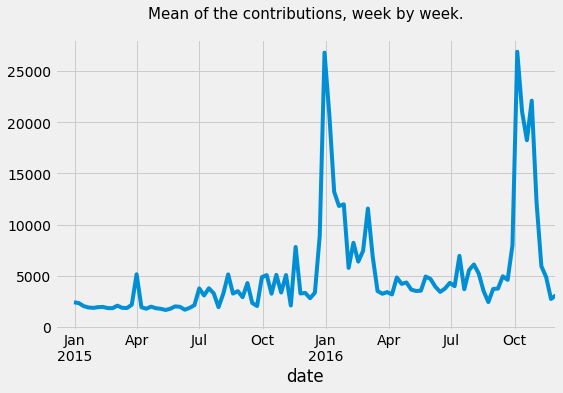

In [50]:
amount_per_week.mean().plot.line()
_ = plt.title('Mean of the contributions, week by week.')

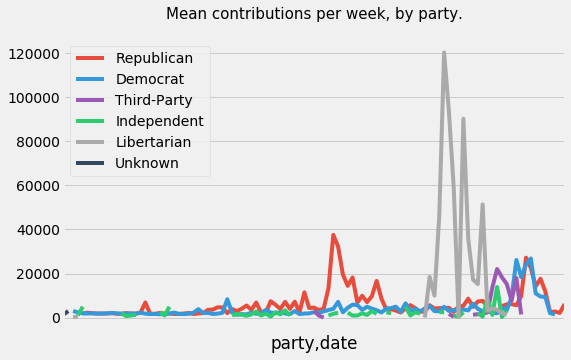

In [72]:
t_df = df.set_index('date').groupby('party').resample('7D').amount.mean()
for party in df.party.unique():
    t_df.loc[party, :].plot.line(label=PARTY_NAME[party], c=PARTY_COLORS[party])
plt.xticks([])
_ = plt.legend()
_ = plt.title('Mean contributions per week, by party.')

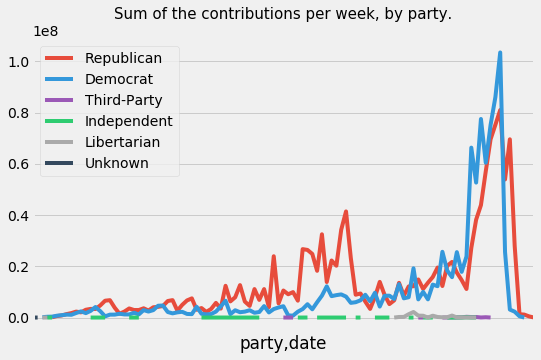

In [77]:
t_df = df.set_index('date').groupby('party').resample('7D').amount.sum()
for party in df.party.unique():
    t_df.loc[party, :].plot.line(label=PARTY_NAME[party], c=PARTY_COLORS[party], sharex=True)
    plt.xticks([])
_ = plt.legend()
_ = plt.title('Sum of the contributions per week, by party.')

## Work In Progress:

In [ ]:
t_df = df.set_index('date').groupby('party').resample('7D').amount.sum().reset_index()
pd.pivot_table(t_df, values='amount', columns='party', index='date').plot()

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, RationalQuadratic
import scipy as sp

date_mask = (df['date'] >= pd.datetime(2015, 1, 1))
t_df = df[date_mask].set_index('date').resample('7D').mean().fillna(0)
t_df.amount = (t_df.amount - t_df.amount.mean()) / t_df.amount.std()

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
#kernel = RationalQuadratic(1.0, 1.0, (1e-5, 1e5))
regr = GaussianProcessRegressor(kernel=kernel)
sample_df = t_df.sample(int(len(t_df) * 1.0), random_state=0)
regr.fit(sample_df.index.asi8.reshape(-1, 1), sample_df.amount.values)

x = pd.date_range(start=t_df.index[0], end=t_df.index[-1], freq='15D')
y_pred, sigma = regr.predict(x.asi8.reshape(-1, 1), return_std=True)

confidence = 0.90
conf_interval = sp.stats.norm.interval(confidence)
plt.plot(x, y_pred, 'b--', label=u'Prediction')
plt.scatter(x, y_pred, s=3, c='black')
plt.plot(t_df.index, t_df.amount, 'r-', label=u'Actual', alpha=0.5)
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred + conf_interval[0] * sigma,
                        (y_pred + conf_interval[1] * sigma)[::-1]]),
         alpha=.2, fc='b', ec='None', label='{}% confidence interval'.format(confidence * 100))
plt.legend()